In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from data_gathering import get_traffic

## Parameters

In [2]:
yesterday = (datetime.now() - timedelta(1))

cameras = {"v1": 3396, "v2": 7785}
start_period = "2023-09-07 14:32:51Z"
end_period = yesterday.strftime('%Y-%m-%d %H:%M:%SZ')

## Get Telraam data 

In [3]:
burel = pd.DataFrame()
for version in cameras:
    burel_tmp = get_traffic(cameras[version], start_period, end_period, level='instances')
    burel_tmp['version'] = version
    burel = pd.concat([burel, burel_tmp], ignore_index=True)

# burel.to_csv(f"data/burel_{yesterday.strftime('%Y%m%d')}.csv", index=False)

In [4]:
burel.columns

Index(['instance_id', 'segment_id', 'date', 'interval', 'uptime', 'heavy',
       'car', 'bike', 'pedestrian', 'heavy_lft', 'heavy_rgt', 'car_lft',
       'car_rgt', 'bike_lft', 'bike_rgt', 'pedestrian_lft', 'pedestrian_rgt',
       'direction', 'car_speed_hist_0to70plus', 'car_speed_hist_0to120plus',
       'timezone', 'v85', 'version'],
      dtype='object')

In [38]:
burel.tail()

,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,heavy_lft,...,bike_lft,bike_rgt,pedestrian_lft,pedestrian_rgt,direction,car_speed_hist_0to70plus,car_speed_hist_0to120plus,timezone,v85,version
1473,7785,-1,2023-10-17T12:00:00.000Z,hourly,0.999722,51.028953,623.334076,9.006682,11.004454,24.020045,...,4.004454,5.002227,4.002227,7.002227,1,"[0.9625656985, 7.706242385, 17.0142598356, 13....","[0.1604276164, 0.8021380821, 3.2096242278, 4.4...",Europe/Paris,57.5,v2
1474,7785,-1,2023-10-17T13:00:00.000Z,hourly,0.999444,67.000000,668.000000,18.000000,12.000000,27.000000,...,6.000000,12.000000,10.000000,2.000000,1,"[2.245508982, 5.5389221557, 10.4790419162, 13....","[0.4491017964, 1.7964071856, 1.9461077844, 3.5...",Europe/Paris,58.0,v2
1475,7785,-1,2023-10-17T14:00:00.000Z,hourly,0.999722,82.046771,948.538976,26.020045,28.011136,40.011136,...,12.008909,14.011136,16.008909,12.002227,1,"[2.7424664353, 5.7997999502, 9.4917984287, 15....","[0.8438719494, 1.898594486, 2.6361019409, 3.16...",Europe/Paris,58.0,v2
1476,7785,-1,2023-10-17T15:00:00.000Z,hourly,0.999167,80.000000,1179.000000,30.000000,21.000000,21.000000,...,10.000000,20.000000,6.000000,15.000000,1,"[4.4105173876, 10.4325699746, 10.0084817642, 1...","[1.3570822731, 3.0534351145, 5.6827820187, 4.7...",Europe/Paris,55.0,v2
1477,7785,-1,2023-10-17T16:00:00.000Z,hourly,0.999444,18.000000,1111.000000,14.000000,5.000000,3.000000,...,2.000000,12.000000,2.000000,3.000000,1,"[1.0801080108, 3.7803780378, 8.5508550855, 11....","[0.0900090009, 0.9900990099, 1.7101710171, 2.0...",Europe/Paris,58.5,v2


## Analysis

Ideas :
- daily aggregation and comparison 
    - global (or just cars + heavy)
    - by transportation mode
    - by directions
- by moment of time :
    - day of week
    - hour
- uptime differences ?
- v85 differences ?
- directions

In [3]:
burel = pd.read_csv('data/burel_20231018.csv')
burel['date'] = pd.to_datetime(burel['date'])
burel['day'] = burel['date'].dt.date
burel['hour'] = burel['date'].dt.hour

### Daily - by Transportation mode

In [30]:
transportation_modes = ['car','bike','pedestrian','heavy']
id_var = ['day','version']
evolution = burel.groupby(id_var)[transportation_modes].sum().reset_index()
evolution = pd.melt(evolution, id_vars=id_var, var_name="mode")

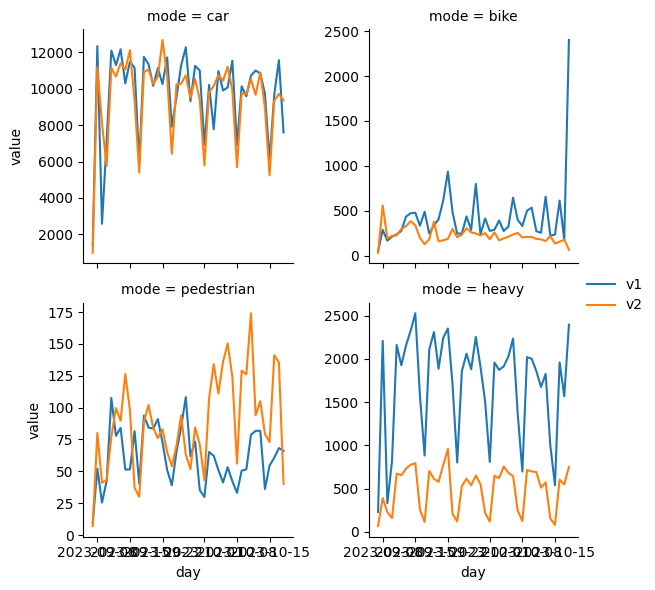

In [31]:
g = sns.FacetGrid(evolution, col="mode", sharey=False, col_wrap=2)
g.map_dataframe(sns.lineplot, x='day', y='value', hue='version', errorbar=None)
g.add_legend()

### Daily - by transportation mode and direction

In [43]:
direction_modes = [mode + '_lft' for mode in transportation_modes] + [mode + '_rgt' for mode in transportation_modes]
id_var = ['day','version']
evolution_direction = burel.groupby(id_var)[direction_modes].sum().reset_index()
evolution_direction = pd.melt(evolution_direction, id_vars=id_var, var_name="mode_direction")
evolution_direction[['mode', 'direction']] = evolution_direction['mode_direction'].str.split("_", expand = True)


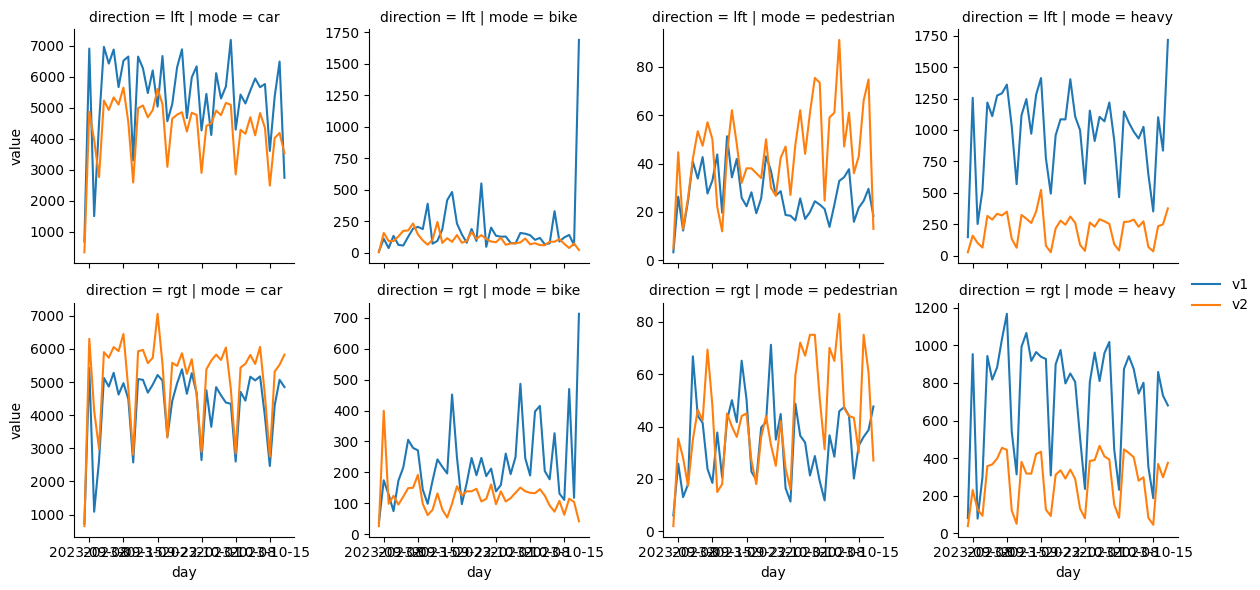

In [46]:
g = sns.FacetGrid(evolution_direction, col="mode", row="direction", sharey=False)
g.map_dataframe(sns.lineplot, x='day', y='value', hue='version', errorbar=None)
g.add_legend()